In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Set style for the plots
plt.style.use('seaborn-v0_8')

In [4]:
# Load predictions
lstm = pd.read_csv("../output/predictions/LSTM_predictions.csv", index_col=0, parse_dates=True)
xgboost = pd.read_csv("../output/predictions/XGBoost_predictions.csv", index_col=0, parse_dates=True)

# Prepare DataFrame
df = lstm.join(
    xgboost[['Predicted']].rename(columns={'Predicted': 'xgb_pred'})
).rename(columns={'Predicted': 'lstm_pred'})

df

,Actual,lstm_pred,xgb_pred
timestamp,,,
2018-01-01,238.78,239.823391,238.53004
2018-01-02,239.14,239.829364,238.44500
2018-01-03,239.71,239.793721,238.31468
2018-01-04,241.00,239.806204,238.72420
2018-01-05,242.20,239.874398,238.64178
...,...,...,...
2020-12-27,226.59,224.298412,226.73595
2020-12-28,227.05,224.636159,226.76233
2020-12-29,227.45,225.940245,229.66463


In [5]:
# Weighted ensemble via linear regression (no intercept)
lr = LinearRegression(fit_intercept=False)
lr.fit(df[['lstm_pred', 'xgb_pred']], df['Actual'])
weights = lr.coef_
df['stack_pred'] = lr.predict(df[['lstm_pred', 'xgb_pred']])

In [6]:
# Simple average ensemble
df['avg_pred'] = df[['lstm_pred', 'xgb_pred']].mean(axis=1)
rmse_avg = np.sqrt(mean_squared_error(df['Actual'], df['avg_pred']))
mae_avg = mean_absolute_error(df['Actual'], df['avg_pred'])

# Weighted ensemble via linear regression (no intercept)
lr = LinearRegression(fit_intercept=False)
lr.fit(df[['lstm_pred', 'xgb_pred']], df['Actual'])
weights = lr.coef_
df['stack_pred'] = lr.predict(df[['lstm_pred', 'xgb_pred']])
rmse_stack = np.sqrt(mean_squared_error(df['Actual'], df['stack_pred']))
mae_stack = mean_absolute_error(df['Actual'], df['stack_pred'])

# Display results
ensemble_summary = pd.DataFrame({
    'Method': ['Simple Average', 'Stacking'],
    'MAE': [mae_avg, mae_stack],
    'RMSE': [rmse_avg, rmse_stack],
    'Weights (LSTM, XGB)': ['(0.5, 0.5)', f'({weights[0]:.3f}, {weights[1]:.3f})']
})

ensemble_summary

,Method,MAE,RMSE,"Weights (LSTM, XGB)"
0,Simple Average,1.087705,1.435495,"(0.5, 0.5)"
1,Stacking,1.083522,1.421757,"(0.438, 0.563)"


In [7]:
anchor_template = [
    ("11-01", 237.30),  # 1 Nov
    ("12-15", 237.30),
    ("01-01", 239.61),
    ("02-01", 241.71),
    ("03-01", 242.70),
    ("04-01", 244.10),
    ("05-01", 244.95),  # 1 May
]

def compute_max_level_series(dates: pd.DatetimeIndex) -> pd.Series:
    def cap_on(day: pd.Timestamp) -> float:
        year0 = day.year if day.month >= 11 else day.year - 1
        pts   = []
        for mm_dd, lvl in anchor_template:
            mm, dd = map(int, mm_dd.split("-"))
            yr     = year0 if mm >= 11 else year0 + 1
            try:
                pts.append((pd.Timestamp(yr, mm, dd), lvl))
            except ValueError:  # 29 Feb on non-leap
                pts.append((pd.Timestamp(yr, 2, 28), lvl))
        pts.sort(key=lambda x: x[0])
        if day < pts[0][0] or day >= pts[-1][0]:
            return pts[-1][1]
        for (d0, l0), (d1, l1) in zip(pts, pts[1:]):
            if d0 <= day <= d1:
                frac = (day - d0) / (d1 - d0)
                return l0 + frac * (l1 - l0)
        return pts[-1][1]

    return pd.Series([cap_on(d) for d in dates], index=dates, name="max_level_m")

--------------------------------------------------
Validation MAE  : 1.0877 m
Validation RMSE : 1.4355 m
--------------------------------------------------


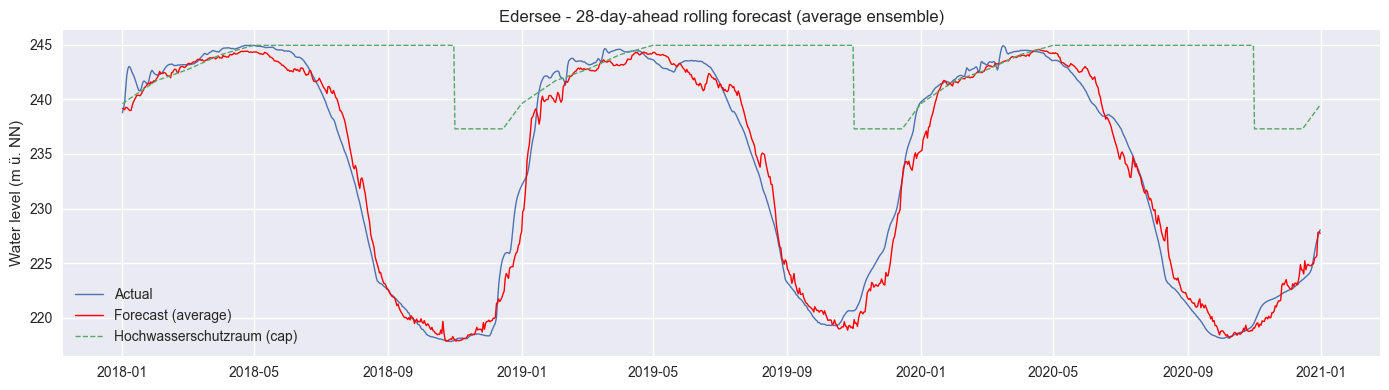

In [8]:
# Prepare series for plotting
plot_dates = df.index
y_actual   = df['Actual']
y_avg      = df['avg_pred']
dyn_cap    = compute_max_level_series(plot_dates).values

print("-" * 50)
print(f"Validation MAE  : {mae_avg:6.4f} m")
print(f"Validation RMSE : {rmse_avg:6.4f} m")
print("-" * 50)

# Plot
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(plot_dates, y_actual, label="Actual", lw=1)
ax.plot(plot_dates, y_avg,    label="Forecast (average)", lw=1, color="red")
ax.plot(plot_dates, dyn_cap,   label="Hochwasserschutzraum (cap)", ls="--", lw=1)
ax.set_ylabel("Water level (m ü. NN)")
ax.set_title("Edersee - 28-day-ahead rolling forecast (average ensemble)")
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()

## Test Period

In [10]:
# Load predictions
lstm = pd.read_csv("../output/predictions/LSTM_test_predictions.csv", index_col=0, parse_dates=True)
xgboost = pd.read_csv("../output/predictions/XGBoost_test_predictions.csv", index_col=0, parse_dates=True)

# Prepare DataFrame
df = lstm.join(
    xgboost[['Predicted']].rename(columns={'Predicted': 'xgb_pred'})
).rename(columns={'Predicted': 'lstm_pred'})

# Simple average ensemble
df['avg_pred'] = df[['lstm_pred', 'xgb_pred']].mean(axis=1)
rmse_avg = np.sqrt(mean_squared_error(df['Actual'], df['avg_pred']))
mae_avg = mean_absolute_error(df['Actual'], df['avg_pred'])

Test results
--------------------------------------------------
Test MAE  : 1.8288 m
Test RMSE : 2.6562 m
--------------------------------------------------


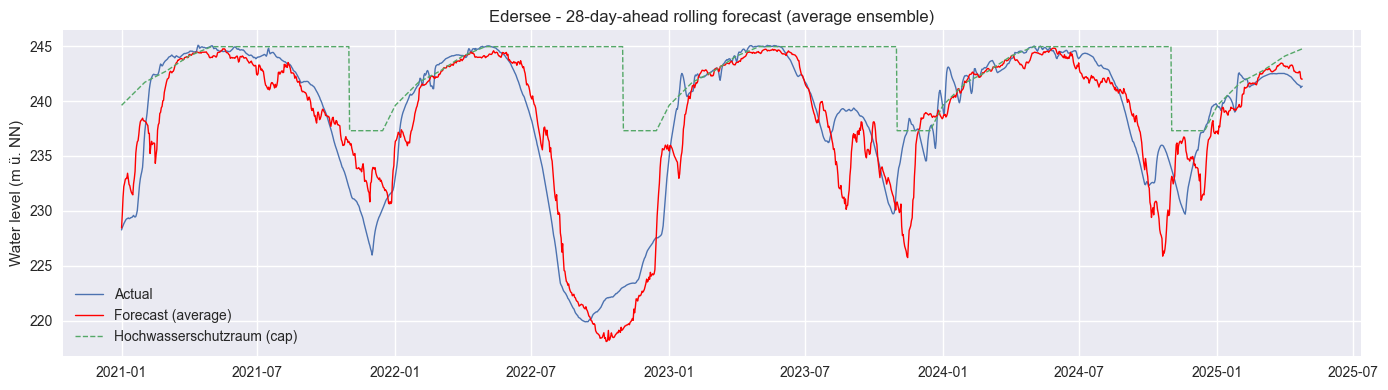

In [11]:
# Prepare series for plotting
plot_dates = df.index
y_actual   = df['Actual']
y_avg      = df['avg_pred']
dyn_cap    = compute_max_level_series(plot_dates).values

print("Test results")
print("-" * 50)
print(f"Test MAE  : {mae_avg:6.4f} m")
print(f"Test RMSE : {rmse_avg:6.4f} m")
print("-" * 50)

# Plot
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(plot_dates, y_actual, label="Actual", lw=1)
ax.plot(plot_dates, y_avg,    label="Forecast (average)", lw=1, color="red")
ax.plot(plot_dates, dyn_cap,   label="Hochwasserschutzraum (cap)", ls="--", lw=1)
ax.set_ylabel("Water level (m ü. NN)")
ax.set_title("Edersee - 28-day-ahead rolling forecast (average ensemble)")
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()